In [5]:
import pandas as pd
import numpy as np
from apiclient.discovery import build
from pymongo import MongoClient
import os
from dotenv import load_dotenv
import string
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.compose import ColumnTransformer
import pickle
import matplotlib.pyplot as plt

# Connecting to DB and loading data...

In [7]:
# connect to mongo cloud db and select collection

load_dotenv()

uri = os.getenv('MONGO_URI')

mongo_client = MongoClient(uri)

db = mongo_client['youtube-db']

In [8]:
# select collections for training and test data

train_col = db['training_col']
test_col = db['test_col']

In [9]:
# fetching data from training collection, might take a view seconds...

data = list(train_col.find())

In [10]:
df = pd.DataFrame(data)
df

,_id,video_id,title,description,category_id
0,628e25946b047126d6d3794b,FfJ5XG5i2aw,introducing teded lessons worth sharing,tededs mission is to capture and amplify the v...,1
1,628e25946b047126d6d3794c,Oi2_qJumnDo,teded lessons worth sharing,,0
2,628e25946b047126d6d3794d,2W85Dwxx218,why do we dream amy adkins,view full lesson httpedtedcomlessonswhydowedre...,1
3,628e25946b047126d6d3794e,LaLvVc1sS20,the history of tea shunan teng,view full lesson httpedtedcomlessonsthehistory...,1
4,628e25946b047126d6d3794f,MMmOLN5zBLY,the benefits of a bilingual brain mia nacamulli,check out our patreon page httpswwwpatreoncomt...,1
...,...,...,...,...,...
77468,628fdbf42ea84f31c91ecf80,RPz_XktsEFE,euphoria season 2 official tease hbo,january 9 hbo maxeuphoria\r\rzendaya leads an ...,0
77469,628fdbf42ea84f31c91ecf81,ffcitRgiNDs,adele easy on me live at the nrj awards 2021,easy on me by adele live at the nrj awards 202...,0
77470,628fdbf42ea84f31c91ecf82,reEiGS35Iuc,minecraft copper golem morphing,⭐check out my channel override httpswwwyoutu...,0
77471,628fdbf42ea84f31c91ecf83,TPAoof3GSyE,glee did not age well,use code eddy14 for up to 14 free meals 3 fre...,0


# Building and testing ML models

In [11]:
# splitting data into training and test data

X = df['title'] + " " + df['description']
y = df['category_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# loading new random data

test_data = list(test_col.find())

test_df = pd.DataFrame(test_data)

X_new = test_df['title'] + " " + test_df['description']
y_new = test_df['category_id']

# SGD Classifier

In [12]:
# Building ML Pipeline

sgd_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=1000, tol=None)),
    ])

In [187]:
sgd_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', SGDClassifier(alpha=0.001, random_state=42, tol=None))])

In [188]:
# Evaluating metrics on test data

predicted = sgd_clf.predict(X_test)

print("Metrics on test data from split:")

print(metrics.classification_report(predicted, y_test))

# Evaluating clf against completly new random data

predicted_new = sgd_clf.predict(X_new)

print("Metrics on new random data:")

print(metrics.classification_report(predicted_new, y_new))

Metrics on test data from split:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      7970
           1       0.15      0.99      0.27       140

    accuracy                           0.91      8110
   macro avg       0.58      0.95      0.61      8110
weighted avg       0.99      0.91      0.94      8110

Metrics on new random data:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      4948
           1       0.13      1.00      0.23        52

    accuracy                           0.93      5000
   macro avg       0.57      0.97      0.60      5000
weighted avg       0.99      0.93      0.96      5000



# Random Forest Classifier

In [204]:
# Building ML Pipeline

rf_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', RandomForestClassifier()),
    ])

In [205]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', RandomForestClassifier())])

In [206]:
# Evaluating metrics on test data

predicted = rf_clf.predict(X_test)

print(metrics.classification_report(predicted, y_test))

# Evaluating clf against completly new random data

predicted_new = rf_clf.predict(X_new)

print("Metrics on new random data:")

print(metrics.classification_report(predicted_new, y_new))

print(metrics.confusion_matrix(predicted_new, y_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7185
           1       0.98      1.00      0.99       925

    accuracy                           1.00      8110
   macro avg       0.99      1.00      0.99      8110
weighted avg       1.00      1.00      1.00      8110

Metrics on new random data:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4743
           1       0.63      0.98      0.77       257

    accuracy                           0.97      5000
   macro avg       0.81      0.97      0.88      5000
weighted avg       0.98      0.97      0.97      5000

[[4596  147]
 [   6  251]]


# Multi Layer Perceptron Classifier

In [13]:
# Building ML Pipeline

mlp_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', MLPClassifier(verbose=True))
])

In [14]:
mlp_clf.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/default/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MLPClassifier(verbose=True))])

In [217]:
# Evaluating metrics on test data

predicted = mlp_clf.predict(X_test)

print(metrics.classification_report(predicted, y_test))

# Evaluating clf against completly new random data

predicted_new = mlp_clf.predict(X_new)

print("Metrics on new random data:")

print(metrics.classification_report(predicted_new, y_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7176
           1       0.99      1.00      0.99       934

    accuracy                           1.00      8110
   macro avg       0.99      1.00      1.00      8110
weighted avg       1.00      1.00      1.00      8110

Metrics on new random data:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      9366
           1       0.71      0.97      0.82       634

    accuracy                           0.97     10000
   macro avg       0.85      0.97      0.90     10000
weighted avg       0.98      0.97      0.97     10000



In [ ]:
analysis = test_df[test_df["category_id"] == 1] 
analysis[100:150]

# <mark>TODO</mark>: Grid Search for optimal params

In [15]:
# setup train and test data (with subset of original data)

random_train = df.sample(n=20000)
random_test = test_df.sample(n=5000)

X = random_train['title'] + " " + random_train['description']
y = random_train['category_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

X_new = random_test['title'] + " " + random_test['description']
y_new = random_test['category_id']

In [16]:
# Building ML Pipeline, using HashingVectorizer

mlp_clf = Pipeline([
    ('hvec', HashingVectorizer(strip_accents='ascii', stop_words='english', ngram_range=(1, 2))),
    ('clf', MLPClassifier(hidden_layer_sizes=(32, 32), verbose=True, warm_start=True))
])

In [17]:
mlp_clf['clf'].n_iter_ = 0
mlp_clf['clf'].best_loss_ = 1
mlp_clf.fit(X_train, y_train)

Iteration 1, loss = 0.47051191
Iteration 2, loss = 0.08992149
Iteration 3, loss = 0.01292219
Iteration 4, loss = 0.00511756
Iteration 5, loss = 0.00306152


/opt/homebrew/Caskroom/miniforge/base/envs/default/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('hvec',
                 HashingVectorizer(ngram_range=(1, 2), stop_words='english',
                                   strip_accents='ascii')),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(32, 32), verbose=True,
                               warm_start=True))])

In [18]:
# Evaluating metrics on test data

predicted = mlp_clf.predict(X_test)

print(metrics.classification_report(predicted, y_test))

# Evaluating clf against completly new random data

predicted_new = mlp_clf.predict(X_new)

print("Metrics on new random data:")

print(metrics.classification_report(predicted_new, y_new))

print(metrics.confusion_matrix(predicted_new, y_new))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1812
           1       0.93      0.99      0.96       188

    accuracy                           0.99      2000
   macro avg       0.96      0.99      0.98      2000
weighted avg       0.99      0.99      0.99      2000

Metrics on new random data:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      4681
           1       0.72      0.98      0.83       319

    accuracy                           0.97      5000
   macro avg       0.86      0.98      0.91      5000
weighted avg       0.98      0.97      0.98      5000

[[4556  125]
 [   5  314]]


In [23]:
# save and load model

path = "../models/mlp_32x32_model.sav"
pickle.dump(mlp_clf, open(path, "wb"))
mlp_clf = pickle.load(open(path, "rb"))

# Update method could look like this...

In [1]:
def update_ml_model():
    old_data = train_col.find()
    new_data = user_train_col.find()
    
    old_df = pd.DataFrame(old_data)
    new_df = pd.DataFrame(new_data)
    
    df = pd.concat([old_df, new_df])
    
    X_train = df['title'] + " " + df['description']
    y_train  = df['category_id']
    
    mlp_clf.fit(X_train, y_train)

# ROC Analysis

In [24]:
mlp_clf = pickle.load(open("../models/mlp_32x32_model.sav", "rb"))
y_score = mlp_clf.predict_proba(X_new)

fpr, tpr, thresholds = metrics.roc_curve(y_new, y_score[:, -1], pos_label=1, sample_weight=None, drop_intermediate=True)
roc_auc = metrics.auc(fpr, tpr)

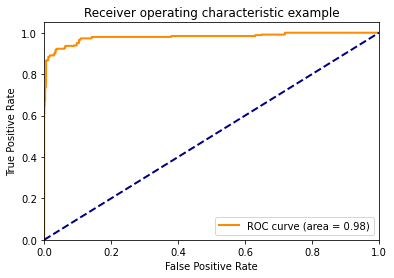

In [25]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()